# Text to Speech

When solving some problem with deep learning in practice, you search the Web for the latest paper that solves that task, and take its implementation from GitHub. However, often there is no code, so being able to **reimplement a paper** is a vital skill. You will likely have to do it in your course project, and we are going to practice it in this assignment.

Let's focus on the task of text-to-speech (**TTS**) synthesis.

![](https://user-images.githubusercontent.com/9570420/81783573-392ed600-9504-11ea-98da-86ac05457c29.png)

## Data

 Intuitively, in the real world your dataset would be a set of pairs:

* text (string);
* **target**: raw audio of a person saying `text` (array of amplitude values sampled e.g. 44100 times per second — see an example plotted above).

We give you a simplified problem statement, with one dataset sample being an utterance described by

* list of [ARPAbet phonemes](http://www.speech.cs.cmu.edu/cgi-bin/cmudict#phones);
* *phoneme alignment*, i.e. start time (frame) and duration for each phoneme;
* **target**: [mel spectrogram](https://pytorch.org/audio/transforms.html#torchaudio.transforms.MelSpectrogram) of a person saying text.

![image](https://user-images.githubusercontent.com/9570420/81795777-2a9cea80-9515-11ea-99eb-05915f803af1.png)

In [0]:
import scipy.io.wavfile

import torch
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import random
from pathlib import Path

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [2]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/Deep Learning 2020 -- Home Assignment 4-1")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgotten to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.insert(0, str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
![ ! -d "LJ-Speech-aligned" ] && unzip -q "{AUX_DATA_ROOT / 'LJ-Speech-aligned.zip'}"
!git clone --recursive https://github.com/shrubb/waveglow.git -b denoiser-fix
!wget -c https://api.ngc.nvidia.com/v2/models/nvidia/waveglow_ljs_256channels/versions/2/files/waveglow_256channels_ljs_v2.pt

fatal: destination path 'waveglow' already exists and is not an empty directory.
--2020-05-24 19:55:23--  https://api.ngc.nvidia.com/v2/models/nvidia/waveglow_ljs_256channels/versions/2/files/waveglow_256channels_ljs_v2.pt
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 52.89.201.137, 35.161.182.61
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|52.89.201.137|:443... connected.
HTTP request sent, awaiting response... 302 
Location: https://s3.us-west-2.amazonaws.com/prod-model-registry-ngc-bucket/org/nvidia/models/waveglow_ljs_256channels/versions/2/files/waveglow_256channels_ljs_v2.pt?response-content-disposition=attachment%3B%20filename%3D%22waveglow_256channels_ljs_v2.pt%22&response-content-type=application%2Foctet-stream&X-Amz-Security-Token=IQoJb3JpZ2luX2VjECMaCXVzLXdlc3QtMiJHMEUCIFo8sQIMBbRU1RDVcE73rVV6IRwaIih90MvI6anB%2FME%2BAiEA1aefTgWrN5vB94FRCW0zFBsJ7GLjE5VTHIRYlN2WBJQqtAMIfBACGgw3ODkzNjMxMzUwMjciDGVTWsj2aWtFEqxeVyqRA4Bdui2GXQ2mm8%2BkBg0dNtvzHEoC1nQWF1CPpWtFqdQXq2Z

Use this Python module to handle our dataset. It's documented, so when in doubt, use `help()` or read the code with `??lj_speech`.

In [4]:
! pip install git+https://github.com/shrubb/listener.git

  Cloning https://github.com/shrubb/listener.git to /tmp/pip-req-build-si7_4hiu
  Running command git clone -q https://github.com/shrubb/listener.git /tmp/pip-req-build-si7_4hiu
  Created wheel for listener: filename=listener-1.0.0a1-cp36-none-any.whl size=87098 sha256=9a44ee68dd7f508c7dbff551655f885142d308ac884828c93645fb9c38c30c26
  Stored in directory: /tmp/pip-ephem-wheel-cache-l3rlubvz/wheels/41/ec/98/7c89227ba5da35ff1e7d5284bb58e0b98e93389fc1f77c407b
Successfully built listener


In [0]:
import lj_speech

In [0]:
DATASET_ROOT = Path('LJ-Speech-aligned/')

train_dataset, val_dataset = lj_speech.get_dataset(DATASET_ROOT)

There are also a couple of useful constants, check them with `?lj_speech`.

In [7]:
len(lj_speech.POSSIBLE_PHONEME_CODES)

54

Here is an example datapoint:

Datasets yield: text, phonemes_start, phonemes_duration, phonemes_code, spectrogram


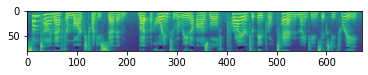

In [8]:
example_datapoint = train_dataset[666]
print(f"Datasets yield: {', '.join(example_datapoint.keys())}")
plt.imshow(example_datapoint['spectrogram']);

In [9]:
len(train_dataset), train_dataset[1]

(12971,
 {'phonemes_code': ['W',
   'EH1',
   'N',
   'K',
   'W',
   'IH1',
   'G',
   'L',
   'IY0',
   'R',
   'IH0',
   'T',
   'EU1',
   'R',
   'N',
   'D',
   'T',
   'UW1',
   'HH',
   'IH0',
   'Z',
   'AO1',
   'F',
   'AH0',
   'S',
   'pau',
   'HH',
   'IY1',
   'L',
   'EU1',
   'R',
   'N',
   'D',
   'pau'],
  'phonemes_duration': [3,
   6,
   7,
   6,
   4,
   6,
   5,
   5,
   9,
   4,
   4,
   10,
   4,
   11,
   3,
   10,
   9,
   9,
   6,
   3,
   8,
   15,
   8,
   7,
   4,
   3,
   3,
   9,
   8,
   7,
   12,
   6,
   6,
   5],
  'phonemes_start': [0,
   3,
   9,
   16,
   22,
   26,
   32,
   37,
   42,
   51,
   55,
   59,
   69,
   73,
   84,
   87,
   97,
   106,
   115,
   121,
   124,
   132,
   147,
   155,
   162,
   166,
   169,
   172,
   181,
   189,
   196,
   208,
   214,
   220],
  'spectrogram': array([[ -8.291868 ,  -7.3187704,  -7.571682 , ...,  -8.536817 ,
           -8.570963 ,  -8.073748 ],
         [ -7.1034827,  -6.142535 ,  -6.3361983, ...,

In [10]:
len(example_datapoint['phonemes_code']), len(example_datapoint['phonemes_duration']), len(example_datapoint['phonemes_start']), example_datapoint['spectrogram'].shape, len(example_datapoint['text'])

(86, 86, 86, (80, 671), 108)

In [11]:
PAD, UNK = 'PAD', 'UNK'
possible_phonemes = list(lj_speech.POSSIBLE_PHONEME_CODES)
possible_phonemes = [PAD, UNK] + possible_phonemes
phoneme_to_id = {phoneme: num for num, phoneme in enumerate(possible_phonemes)}
phoneme_to_id

{'AA1': 26,
 'AE0': 37,
 'AE1': 30,
 'AH0': 17,
 'AH1': 45,
 'AO0': 28,
 'AO1': 33,
 'AW0': 54,
 'AW1': 16,
 'AY0': 34,
 'AY1': 22,
 'B': 18,
 'CH': 23,
 'D': 11,
 'DH': 25,
 'EH0': 49,
 'EH1': 48,
 'EU0': 8,
 'EU1': 38,
 'EY0': 21,
 'EY1': 55,
 'F': 32,
 'G': 27,
 'HH': 24,
 'IH0': 31,
 'IH1': 20,
 'IY0': 12,
 'IY1': 15,
 'JH': 42,
 'K': 10,
 'L': 6,
 'M': 53,
 'N': 13,
 'NG': 19,
 'OW0': 41,
 'OW1': 7,
 'OY0': 29,
 'OY1': 47,
 'P': 50,
 'PAD': 0,
 'R': 51,
 'S': 39,
 'SH': 9,
 'T': 44,
 'TH': 43,
 'UH0': 14,
 'UH1': 5,
 'UNK': 1,
 'UW0': 3,
 'UW1': 46,
 'V': 35,
 'W': 36,
 'Y': 40,
 'Z': 4,
 'ZH': 2,
 'pau': 52}

To "play" spectrograms, including those that you will generate, we will use another deep learning algorithm called [WaveGlow](https://arxiv.org/abs/1811.00002). It converts mel spectrograms to audio.

Fortunately, there *is* code for it on GitHub, so you won't have to reimplement it 🙂 Still, if you haven't done so, I encourage you to watch a short [video](https://www.youtube.com/watch?v=CqFIVCD1WWo) about a famous paper that it's based on.

In [0]:
vocoder = lj_speech.Vocoder()

In [13]:
print(example_datapoint['text'])

example_spectrogram = torch.from_numpy(example_datapoint['spectrogram'])
audio = vocoder(example_spectrogram)
lj_speech.play_audio(audio)

sometime after march twenty-seven, but according to marina oswald, prior to april ten, nineteen sixty-three,


Finally, we have phonemes as inputs, but we'd like to synthesize arbitrary text. For that, there is a function `lj_speech.text_to_phonemes(text)`.

## Method

Reimplement the baseline method defined by the diagram below. It's derived from a simplified version of the [DurIAN paper](https://arxiv.org/abs/1909.01700).

Just in case, here are some of the most notable differences from DurIAN:
* Prosodic boundary markers aren't used (we don't have them labeled), and thus there's no 'skip states' exclusion of prosodic boundaries' hidden states.
* Style codes aren't used too (same).
* Simpler network architectures.
* No pre-net in decoder.
* No attention used in decoder.
* Decoder's recurrent cell outputs single spectrogram frame at a time.
* Decoder's recurrent cell isn't conditioned on its own outputs (isn't "autogressive").

![pipeline](https://user-images.githubusercontent.com/9570420/81863803-6f0ba300-9574-11ea-9f02-481c2bba81f0.png)

This picture is the simplified Figure 1 from the paper. **Use the paper as a reference**. If something is unclear from the diagram — and, in fact, some things are intentionally omitted — search answers in the paper (but remain aware of the differences/simplifications in the above diagram) and other papers that the authors cite. There will even be details that aren't even mentioned anywhere in the paper, so you'll have to guess by your intuition. For instance, DurIAN paper doesn't explain batch size and sampling strategy, and even if it did, it would be irrelevant since we use different data. Finally, search the Web and read others' code; however, if you copy-paste code, **cite it**.

Tips:
* Only compute loss on the 'original' parts of the spectrograms (don't include padding)!
* When using recurrent nets, [clip gradients' norm](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.clip_grad_norm_).
* Since you will use recurrent nets, and the sequences in a batch will be of different lengths, you may find [sequence packing utility](https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch) useful.
* Remember that you can send images and audio into TensorBoard, too.

**Train this baseline so that the words are well-recognizable, and try to get rid of the "metallic", "tin sounding" voice.**

**Aim for something like this:**

In [14]:
lj_speech.play_audio(scipy.io.wavfile.read(AUX_DATA_ROOT / 'ok.wav')[1])

**On the other hand, here is an example of insufficient quality:**

In [15]:
lj_speech.play_audio(scipy.io.wavfile.read(AUX_DATA_ROOT / 'bad.wav')[1])

## Baseline

In [0]:
import os
import random
from datetime import datetime

import numpy as np

import torch
from torch import nn
# from torch.utils.tensorboard import SummaryWrite

In [0]:
class SkipEncoder(nn.Module):
    def __init__(self, input_dim, hid_dim):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, hid_dim)
        
        self.prenet = nn.Sequential(
            nn.Conv1d(hid_dim, 256, kernel_size=5),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv1d(256, 256, kernel_size=5),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv1d(256, 512, kernel_size=5),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv1d(512, 512, kernel_size=5),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv1d(512, 512, kernel_size=5),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.gru = nn.GRU(512, 256 + 256, bidirectional=True)
        
    def forward(self, x):
        """
        x (batch of phoneme indices): torch.long tensor of shape [bs, seq_len]
        
        returns (encoded sequence): torch.float32 tensor of shape [bs, seq_len, output_dim]
        """
        emb = self.embedding(x)
        emb = torch.transpose(emb, 1, 2)
        prenet_out = self.prenet(emb)
        prenet_out = torch.transpose(prenet_out, 1, 2)
        _, hidden = self.gru(prenet_out)
        # nn.utils.clip_grad_norm_(parameters, max_norm, norm_type=2)

        return hidden

In [0]:
class Alignment(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, hidden, durations):
        """
        hidden (batch of token indices): torch.long tensor of shape [bs, seq_len]
        durations: torch.long tensor of shape [bs, seq_len]

        returns (acoustic frames): torch.float32 tensor of shape [bs, seq_len, output_dim]
        """
        total_len = torch.sum(durations)
        replicated = torch.tensor(hidden.size(0), hidden.size(1), total_len).cuda() # .to(device)
        
        for duration, hid_ph in zip(durations, hidden):
            for _ in duration:
                replicated = ...

        return hidden

In [0]:
class Duration(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        self.input_dim = input_dim
        self.batch_size = 1 # hardcoded
        self.hidden_size = 3
        self.lstm = nn.LSTM(82, self.hidden_size, num_layers=input_dim, bidirectional=True)
        self.dense = nn.Linear(82, 512)

    def forward(self, emb):
        """
        emb (batch of phoneme embeddings): torch.long tensor of shape [bs, seq_len]

        returns (durations): torch.float32 tensor of shape [bs, seq_len, output_dim]
        """
        h0 = torch.randn(self.input_dim*2, self.batch_size, self.hidden_size)
        c0 = torch.randn(self.input_dim*2, self.batch_size, self.hidden_size)
        emb = emb.unsqueeze(0)
        lstm_out, hidden = self.lstm(emb, (h0, c0))
        # nn.utils.clip_grad_norm_(parameters, max_norm, norm_type=2)
        durations = self.dense(lstm_out)

        return durations

In [0]:
class Decoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        self.gru = nn.GRU(input_dim, 256, num_layers=2, bidirectional=True)

        self.conv_block = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=5),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout(0.0)
        )
        self.conv1 = nn.Conv1d(256, 256, kernel_size=1)
        
        self.conv_to_pred1 = nn.Conv1d(256, 256, kernel_size=1)
        self.conv_to_pred2 = nn.Conv1d(256, 256, kernel_size=1)
        
    def forward(self, x):
        """
        x (batch of token indices): torch.long tensor of shape [bs, seq_len]
        
        returns (encoded sequence): torch.float32 tensor of shape [bs, seq_len, output_dim]
        """
        # b = torch.nn.utils.rnn.pad_sequence(a, batch_first=True)
        # torch.nn.utils.rnn.pack_padded_sequence(b, batch_first=True, lengths=[3,2])
        # packed_embedded = nn.utils.rnn.pack_padded_sequence(seq, text_lengths)
        gru_out = self.gru(x)
        # nn.utils.clip_grad_norm_(parameters, max_norm, norm_type=2)

        output1 = self.conv_to_pred1(gru_out)

        for _ in range(5):
            res1 = self.conv_block(gru_out)
            res2 = self.conv1(gru_out)
            gru_out = res1 + res2

        output2 = self.conv_to_pred2(gru_out)

        return output1, output2

# how to make universal input_size for nn.GRU in the Decoder block, because after 
# each padded packing we get non-constant value for different batches? 

# torch.nn.utils.rnn.pad_packed_sequence(...) does stuff only along time dimension, 
# on the other hand, ‘input size’ parameter considers number of channels in your input, 
# which is another dimension. Probably, check out yourself for mistake

## Improving the Method

When you have the baseline working, seek the ways to improve quality and to decrease loss. Look into the paper and the relevant/neighbouring literature. Also, follow your intuition, e.g. for changing model complexity or regularization. For example, you can (but aren't obliged to) try borrowing more tricks from DurIAN; a couple of examples for inspiration:

* Make decoder recurrent cell autoregressive as in the paper: use its output as its input at the next preiction step.
* Add pre-net to decoder.
* Add attention to decoder.
* Use more complex sub-network architectures (e.g. use CBHG).
* Employ tricks from Tacotron {[1](https://arxiv.org/abs/1703.10135),[2](https://arxiv.org/abs/1712.05884)} — papers that DurIAN is based upon, e.g. [zoneout](https://arxiv.org/abs/1606.01305) in RNNs.

Write a report on your journey to better loss. Explain if you managed to perceptibly improve the quality and lower the loss, what you tried and why, what worked and what didn't. Include TensorBoard loss plots.

## Deliverables

1. This file, fully functional, reproducing all the reported results on "Run all". Out-of-the box `TextToSpeechSynthesizer` class (see interface below) and demo code of running it on arbitrary text.
2. Report on improving the baseline at the end of this file.
3. Two "checkpoint files" with weights for both of your models (baseline and the improved model).

## Grading

* **[7 points]** Baseline.
* **[3 points]** Improving of the baseline.

In [0]:
class TextToSpeechSynthesizer(nn.Module):
    """
    When done, please fill this class. It should work out-of-the-box, i.e.
    have a simple interface, automatically load model weights,
    process text to speech at one command without errors etc.
    """
    def __init__(self, input_dim=4, hid_dim=3):# checkpoint_path, <any-other-arguments>):
        """
        Initialize anything you may need. For example, load model weights from disk.
        """
        super().__init__()

        self.encoder = SkipEncoder(input_dim, hid_dim)
        self.alignment = Alignment()
        self.duration = Duration(input_dim)
        self.decoder = Decoder(input_dim)
    
    def synthesize_from_text(self, text):
        """
        Synthesize text into voice.

        text:
            str
        
        return:
        audio:
            torch.Tensor or numpy.ndarray, shape == (1, t)
        """
        phonemes = lj_speech.text_to_phonemes(text)
        return self.synthesize_from_phonemes(phonemes)

    def synthesize_from_phonemes(self, phonemes, durations=None):
        """
        Synthesize phonemes into voice.

        phonemes:
            list of str
            ARPAbet phoneme codes.
        durations:
            list of int, optional
            Duration in spectrogram frames for each phoneme.
            If given, will be used for hard alignment in the model (like during
            training); otherwise, durations will be predicted by the duration
            model.
        
        return:
        audio:
            torch.Tensor or numpy.ndarray, shape == (1, t)
        """
        # Your code here

        # spectrogram = ...
        # return vocoder(spectrogram)

    def forward(self, phonemes, durations=None):
        ph_hidden = self.encoder(phonemes)
        if durations is not None:
             durations = self.duration(phonemes)
        ph_aligned = self.alignment(ph_hidden, durations)
        
        # out1, out2 = self.decoder(ph_aligned)

In [0]:
PAD_IX, UNK_IX = phoneme_to_id[PAD], phoneme_to_id[UNK]

# from seminars
def as_matrix(sequences, max_len=None):
    """Convert a list of tokens into a matrix with padding"""
    
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i, seq in enumerate(sequences):
        row_ix = [phoneme_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [0]:
# torch.tensor(as_matrix([train_dataset[i]['phonemes_code'] for i in range(3)]))

In [0]:
def make_batch(dataset, batch_size):
    length = len(dataset)
    arange = torch.arange(length)
    rest = length / batch_size
    indices = arange[:-rest].reshape(-1, batch_size)

    for indices_part in indices:
        batch = [dataset[i] for i in range(indices_part)]
        yield batch

In [0]:
def run_epoch(model, optimizer, criterion, phase='train', epoch=0, writer=None):
    is_train = (phase == 'train')
    
    with torch.set_grad_enabled(is_train):
        for i, batch in enumerate(train_dataset):
            code = torch.tensor(as_matrix([batch["phonemes_code"]])).long().to(device)
            duration = torch.tensor(as_matrix([batch["phonemes_duration"]])).long().to(device)
            start = torch.tensor(as_matrix([batch["phonemes_start"]])).long().to(device)
            # spectrogram = torch.tensor(as_matrix([batch["spectrogram"]])).long().to(device)

            pred = model(code, duration)
            loss = criterion(pred, spectrogram)
            
            # if is_train:
            #     optimizer.zero_grad()
            #     loss.backward()
            #     optimizer.step()
                
            # calculate accuracy

In [0]:
train_dataset_list = [data for data in train_dataset]

In [0]:
synthesizer = TextToSpeechSynthesizer(input_dim=54).to(device)
phonemes = "DH IH1 S pau pau pau IH1 Z pau pau pau S P AH1 R T AH1 AH1 AH1 pau".split()

In [0]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(synthesizer.parameters(), lr=1e-4, betas=(0.9, 0.98))
optimizer = None
n_epochs = 1

best_val_loss = float('+inf')
for epoch in range(n_epochs):
    run_epoch(synthesizer, optimizer, criterion, phase='train', epoch=epoch)

### Real

In [0]:
# Example:
# synthesizer = TextToSpeechSynthesizer("./baseline.pth", <any-other-arguments>)

In [0]:
phonemes = "DH IH1 S pau pau pau IH1 Z pau pau pau S P AH1 R T AH1 AH1 AH1 pau".split()
lj_speech.play_audio(
    synthesizer.synthesize_from_phonemes(phonemes))

In [0]:
text = "Pack my box with five dozen liquor jugs."
# text = "The five boxing wizards jump quickly."
# text = "The quick brown fox jumps over the lazy dog."
# text = "How about some school tech."
# text = "Last homework. We are in a deep trouble. No sleep tonight."

lj_speech.play_audio(
    synthesizer.synthesize_from_text(text))

### Dear TAs,

I did not manage to complete this notebook in time.
* What I have done:
 1.   Read the article carefully
 2.   Wrote the classes of the model according to the picture
 3.   Filled 

* What I tried to do next:
 1.   I did not figure out how to convert `torch.utils.data.Dataset` to `torchtext.Dataset`, so, firstly, I tried to pass it to `torch.utils.Dataloader`, then I wrote a `make_batch` function for the first time.
 2.   I tried to pass one batch through the model. It passed through SkipEncoder, but when I debugged Duration block, colab said: `Your session crashed for an unknown reason`, so, due to it and the lack of time I did not debug the rest.

* What would I try if I had more time:
 1.  Make a better batch generation
 2.  Make layers replication in the Alignment block
 3.  Debug all the layers
 4.  Add gradient clipping and sequence packing
 5.  Make the plots
